##  Setting Enviroment

Installing dependencies

In [ ]:
!pip install ta
!pip install pandas_ta
!pip install tqdm

!git clone https://github.com/ztuntrade/untrade-sdk.git
!pip install ./untrade-sdk/.

fatal: destination path 'untrade-sdk' already exists and is not an empty directory.
Processing ./untrade-sdk
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for untrade: filename=untrade-0.1.0-py3-none-any.whl size=5082 sha256=31197b3357f64b30ee36b40c8baf39aa49051fa7e417fb9f79f49806376b6a57
  Stored in directory: /root/.cache/pip/wheels/29/c8/c6/b5ec5185ff18cd2e956de7d1835f1e47ca6b9c115449fce17a
Successfully built untrade
  Attempting uninstall: untrade
    Found existing installation: untrade 0.1.0
    Uninstalling untrade-0.1.0:
      Successfully uninstalled untrade-0.1.0


Importing

In [ ]:
from types import ClassMethodDescriptorType
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
import os
import ta
import numpy as np
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots


import uuid
import os
from untrade.client import Client

##Reading data

In [ ]:
def read_csv_to_dataframe(file_path):
    df = pd.read_csv(file_path)
    # Skip the first row if it contains column headers instead of df
    if df.iloc[0, 0] == 'datetime':  # Or check for other column header names
        df = df.iloc[1:]
    df["datetime"] = df["datetime"].str.replace(".000", "")
    # Try parsing with the original format first
    try:
        df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
        # df['datetime'] = pd.to_datetime(df['datetime'], format='%m-%d-%Y %H:%M')
        # df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%Y %H:%M')
    # If it fails, try parsing with only date format
    except ValueError:
        # df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
        df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y %H:%M')
        # df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y')
        # df['datetime'] = pd.to_datetime(df['datetime'], format='%m-%d-%Y')
        # df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%Y %H:%M')
    df = df[df.high != df.low]
    df.set_index("datetime", inplace=True)
    return df

def read_data_folder(folder_path="./df"):
    dataframes = []
    file_names = []
    for file_name in tqdm(os.listdir(folder_path)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = read_csv_to_dataframe(file_path)
            dataframes.append(df)
            file_names.append(file_name)
    return dataframes, file_names

### Strategy Functions

In [ ]:
def calculate_heikin_ashi(df):
    df['ha_close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    df['ha_open'] = (df['open'].shift(1) + df['close'].shift(1)) / 2
    df['ha_high'] = df[['high', 'close', 'open']].max(axis=1)
    df['ha_low'] = df[['low', 'close', 'open']].min(axis=1)
    return df

def calculate_MACD(df):
    df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    return df

# use for SMA df[‘20_SMA’] = df[‘Close Price’].rolling(window = 20, min_periods = 1).mean()
# use for EMA  df['RSI'].ewm(span=5, adjust=False, min_periods=5).mean()

def calculate_RSI(df):
    rsi_object = ta.momentum.RSIIndicator(df['close'])
    df['RSI'] = rsi_object.rsi()   #RSI CALCULATED
   # df['RSI'] = df['RSI'].ewm(span=14, adjust=False, min_periods=9).mean()  # RSI SMOOTHING
    return df

def wwma(values, n):
    """
     J. Welles Wilder's EMA
    """
    return values.ewm(alpha=1/n,min_periods=n,adjust=False).mean()

def atr(df, n=14):
    df = df.copy()
    high = df['high']
    low = df['low']
    close = df['close']
    df['tr0'] = abs(high - low)
    df['tr1'] = abs(high - close.shift())
    df['tr2'] = abs(low - close.shift())
    tr = df[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    df['atr_values']=atr
    return df

def aroon(df, day):
    #Aroon Up and Down Formulas
    df['aroon_up'] = 100 * df.high.rolling(day).apply(lambda x: x.argmax()) / (day)
    df['aroon_down'] = 100 * df.low.rolling(day).apply(lambda x: x.argmin()) / (day)
    return df

# ADX Strategy
def get_adx(high, low, close, lookback,df):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()

    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    df['plus_di']=plus_di
    df['minus_di']=minus_di
    df['adx']=adx_smooth
    return df

##Global Init

In [ ]:
active=0    #to check whether a trade is active or not   # 0:no trade  1:long  -1:short
last_time=0
curr_max=0
tqdm.pandas()

RSI_buy_threshold = 75
RSI_sell_threshold = 25
profit_target =40
stoploss = 0.75
period1 = 5
period2 =10

## Making Signal

In [ ]:
def calculate_stoploss(volatility: float, momentum: float) -> float:
    global stoploss
    """
    Calculate the stop-loss level based on volatility and momentum.

    Args:
        volatility (float): Standard deviation of recent price movements.
        momentum (float): Current market momentum as a ratio (e.g., average price increase).

    Returns:
        float: Stop-loss as a percentage of the current price.
    """
    base_stoploss = 1.5  # Base stop-loss in percent (e.g., 1.5%)

    # Adjust stop-loss based on volatility
    volatility_factor = min(max(volatility * 10, 0.5), 5.0)  # Scale between 0.5% to 5%

    # Adjust stop-loss based on momentum
    momentum_factor = 1 - min(max(momentum, -0.2), 0.3)  # Scale between -20% to +30%

    # Calculate final stop-loss
    stoploss = base_stoploss * volatility_factor * momentum_factor

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_ichimoku(df):
    """
    Calculate Ichimoku Cloud components.

    Args:
        df (pd.DataFrame): DataFrame containing 'High' and 'Low' columns.

    Returns:
        pd.DataFrame: DataFrame with Ichimoku components added.
    """
    high = df['high']
    low = df['low']
    close = df['close']

    # Tenkan-sen (Conversion Line)
    df['Tenkan'] = (high.rolling(window=9).max() + low.rolling(window=9).min()) / 2

    # Kijun-sen (Base Line)
    df['Kijun'] = (high.rolling(window=period1).max() + low.rolling(window=period1).min()) / 2

    # Senkou Span A (Leading Span A)
    df['SenkouA'] = ((df['Tenkan'] + df['Kijun']) / 2).shift(period1)

    # Senkou Span B (Leading Span B)
    df['SenkouB'] = ((high.rolling(window=period2).max() + low.rolling(window=period2).min()) / 2).shift(period1)

    # Chikou Span (Lagging Span)
    df['Chikou'] = close.shift(-period1)

    return df

def plot_ichimoku(df):
    """
    Plot the Ichimoku Cloud indicator.

    Args:
        df (pd.DataFrame): DataFrame containing Ichimoku components.
    """
    plt.figure(figsize=(42, 16))

    # Price plot
    plt.plot(df.index, df['close'], label='Close Price', color='black', linewidth=1.2)

    # Ichimoku components
    plt.plot(df.index, df['Tenkan'], label='Tenkan-sen', color='blue', linewidth=0.8)
    plt.plot(df.index, df['Kijun'], label='Kijun-sen', color='red', linewidth=0.8)
    plt.plot(df.index, df['Chikou'], label='Chikou Span', color='green', linewidth=0.8)

    # Cloud area
    plt.fill_between(df.index, df['SenkouA'], df['SenkouB'], where=df['SenkouA'] >= df['SenkouB'], color='lightgreen', alpha=0.5)
    plt.fill_between(df.index, df['SenkouA'], df['SenkouB'], where=df['SenkouA'] < df['SenkouB'], color='lightcoral', alpha=0.5)

    # Plot settings
    plt.title('Bitcoin Ichimoku Cloud')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

In [ ]:

def Confirmation(df,current_pos):
    global active
    global last_time
    global curr_max
    global RSI_buy_threshold
    global RSI_sell_threshold

    try:  # Wrap the logic in a try-except block

        #INDICATORS FOR LONG SIGNAL
        c1= (df.iloc[current_pos]['MACD'] > df.iloc[current_pos]['MACD_Signal']) & (df.iloc[current_pos-1]['MACD'] <= df.iloc[current_pos-1]['MACD_Signal'])            #MACD BULLISH CROSSOVER
        c2= ((df.iloc[current_pos]['close'] *((1.5)/100)) < (df.iloc[current_pos]['atr_values']))                                                                       #ATR VOLATILITY CHECK
        c3= (df.iloc[current_pos]['volume'] > ((1.5)*(df.iloc[current_pos]['vol_sma_14'])))                                                                             #VOLUME CONFIRMATION

        c5= (df.iloc[current_pos]['RSI'] > RSI_buy_threshold)                                                                                                           #RSI > RSI_buy_threshold CHECK
        c6= (df.iloc[current_pos]['vol_sma_9'] > df.iloc[current_pos]['vol_sma_14'])                                                                                    #FAST_VOLUME_SMA > SLOW_VOLUME_SMA
        c7= ((df.iloc[current_pos]['ema_6'] > df.iloc[current_pos]['ema_12']) & (df.iloc[current_pos]['ema_12'] > df.iloc[current_pos]['ema_18']) )                     #FASTEST_EMA > FAST_EMA and FAST_EMA > SLOW_EMA
        c8= (df.iloc[current_pos]['aroon_up'] < df.iloc[current_pos]['aroon_down'])                                                                                     #AROON UP < AROON DOWN
        c9= (df.iloc[current_pos]['adx'] > 35 and df.iloc[current_pos]['plus_di'] < df.iloc[current_pos]['minus_di'] )

        c10 = (df.iloc[current_pos]['close'] > df.iloc[current_pos]['SenkouA'])  # Price above Senkou Span A
        c11 = (df.iloc[current_pos]['close'] > df.iloc[current_pos]['SenkouB'])  # Price above Senkou Span B
        c12 = (df.iloc[current_pos]['Tenkan'] > df.iloc[current_pos]['Kijun'])   # Tenkan-sen crosses above Kijun-sen
        # c13 = (df.iloc[current_pos]['Chikou'] > df.iloc[current_pos]['close'].shift(26))  # Chikou Span above the price 26 periods ago
        if current_pos >= 26:  # Ensure there are enough rows to shift
            c10 = df.iloc[current_pos]['Chikou'] > df.iloc[current_pos - 26]['close']
        else:
            c10 = False  # Default to False if there aren't enough rows for the shift


        # if(c5 & c6 & c7) :
        # if (c9):
        # if (c5):
        if ((c10&c11&c12) or c5):
            active=1
            curr_max=df.iloc[current_pos]['close']
            return [1,'long']

        #INDICATORS FOR SHORT SIGNAL

        c1= (df.iloc[current_pos]['MACD'] < df.iloc[current_pos]['MACD_Signal']) & (df.iloc[current_pos-1]['MACD'] >= df.iloc[current_pos-1]['MACD_Signal'])           #MACD BEARISH CROSSOVER
        c2= ((df.iloc[current_pos]['close'] *((1.5)/100)) < (df.iloc[current_pos]['atr_values']))                                                                       #ATR VOLATILITY CHECK
        c3= (df.iloc[current_pos]['volume'] > ((1.5)*(df.iloc[current_pos]['vol_sma_14'])))                                                                             #VOLUME CONFIRMATION

        c5= (df.iloc[current_pos]['RSI'] < RSI_sell_threshold)                                                                                                                          #RSI < RSI_sell_threshold CHECK
        c6= (df.iloc[current_pos-1]['vwap'] < df.iloc[current_pos-1]['ema_6']) & (df.iloc[current_pos]['vwap'] > df.iloc[current_pos]['ema_6'])                         #vwap crossover
        c7= ((df.iloc[current_pos]['ema_6'] < df.iloc[current_pos]['ema_12']) & (df.iloc[current_pos]['ema_12'] < df.iloc[current_pos]['ema_18']) )                     #FASTEST_EMA < FAST_EMA and FAST_EMA < SLOW_EMA
        c8= (df.iloc[current_pos]['aroon_up'] > df.iloc[current_pos]['aroon_down'])                                                                                     #AROON UP > AROON DOWN

        # if(c5 & c7) :
        # # if (0):
        #     active=-1
        #     curr_max=df.iloc[current_pos]['close']
        #     return [-1,'short']


        return [0,'None']

    except IndexError:  # Handle IndexError for first few rows
        return [0, 'None']  # Return default values for first few rows

def total_signal(df, current_candle):
    global active
    global last_time
    global curr_max
    global profit_target
    last_time=last_time+1
    current_pos = df.index.get_loc(current_candle)

    if(active==0):
        # Check Buy condition
        last_time=0
        return Confirmation(df, current_pos)

    elif(active==1):
        curr_max=max(curr_max,df.iloc[current_pos]['close'])    #to keep track of the maximum price of the trade

      # long trade sell check
        c1= (df.iloc[current_pos]['close'] > ((profit_target)*(df.iloc[current_pos]['atr_values'])))          #PROFIT TARGET
        # c1= (df.iloc[current_pos]['close'] > (profit_target))
        c2= (df.iloc[current_pos]['volume'] < ((0.8)*(df.iloc[current_pos]['vol_sma_14'])))         #VOLUME DECREASE SIGNAL
        c3= (df.iloc[current_pos]['RSI'] <RSI_sell_threshold)                                                      #RSI <30 CHECK
        # c4= (last_time > 144)
        c5= (df.iloc[current_pos]['adx'] > 35 and df.iloc[current_pos]['plus_di'] > df.iloc[current_pos]['minus_di'])
        c6= (df.iloc[current_pos]['close'] < (stoploss*curr_max))                                       #STOP LOSS

        c7 = (df.iloc[current_pos]['close'] < df.iloc[current_pos]['SenkouA'])  # Price below Senkou Span A
        c8 = (df.iloc[current_pos]['close'] < df.iloc[current_pos]['SenkouB'])  # Price below Senkou Span B
        c9 = (df.iloc[current_pos]['Tenkan'] < df.iloc[current_pos]['Kijun'])   # Tenkan-sen crosses below Kijun-sen
        # c10 = df.iloc[current_pos]['Chikou'] < df.iloc[current_pos]['close'].shift(26)  # Chikou Span below the price 26 periods ago
        if current_pos >= period1:  # Ensure there are enough rows to shift
            c10 = df.iloc[current_pos]['Chikou'] < df.iloc[current_pos - period1]['close']
        else:
            c10 = False  # Default to False if there aren't enough rows for the shift

        if((c7 & c8 & c9& c10) or c3):
        # if (c3):
            active=0
            return [-1,'close']

        else:
            return [0,'None']

    else:
        curr_max=max(curr_max,df.iloc[current_pos]['close'])    #to keep track of the maximum price of the trade

        # short trade sell check
        c1= (df.iloc[current_pos]['close'] > ((profit_target)*(df.iloc[current_pos]['atr_values'])))         #PROFIT TARGET
        c2= (df.iloc[current_pos]['volume'] > ((1.2)*(df.iloc[current_pos]['vol_sma_14'])))        #VOLUME INCREASE SIGNAL
        # c3= (last_time > 2)
        c4= (df.iloc[current_pos]['close'] < (stoploss * curr_max))                                       #STOP LOSS
        # if(c1 & c2 ):
        #     active=0
        #     return [1,'close']

        # else:
        #     return [0,'None']

def add_total_signal(df):
    # Apply the total_signal function and get the results as a Series of lists
    results = df.progress_apply(lambda row: total_signal(df, row.name), axis=1)
    # Extract the signal values and trade types from the results
    df['signals'] = results.apply(lambda x: x[0])  # Get the first element of each list
    df['trade_type'] = results.apply(lambda x: x[1]) # Get the second element of each list

    return df

## Preparation

In [ ]:
def do_it (folder_path):
    dataframes, file_names = read_data_folder(folder_path)
    global profit_target
    global stoploss
    global active

    for i, df in enumerate(dataframes):
        df=get_adx(df['high'], df['low'], df['close'], 14,df)

    # buy_price, sell_price, adx_rsi_signal = adx_rsi_strategy(df['close'], df['adx'], df['plus_di'], df['minus_di'], df['rsi_14'])
        print("working on dataframe ", i, "...")
        df['vol_sma_14'] = df['volume'].rolling(window=14,min_periods=7).mean()
        df['vol_sma_9'] = df['volume'].rolling(window=9,min_periods=7).mean()
        df['ema_6']=df['close'].ewm(span=6, adjust=False, min_periods=6).mean()
        df['ema_12']=df['close'].ewm(span=12, adjust=False, min_periods=10).mean()
        df['ema_18']=df['close'].ewm(span=18, adjust=False, min_periods=17).mean()
        df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
        df['cumulative_price_volume'] = df['typical_price'] * df['volume']
        df['cumulative_volume'] = df['volume'].cumsum()
        df['cumulative_price'] = df['cumulative_price_volume'].cumsum()
        df['vwap'] = df['cumulative_price'] / df['cumulative_volume']
        df = calculate_MACD(df)
        df = calculate_RSI(df)
        df= calculate_heikin_ashi(df)
        df=atr(df)
        df=aroon(df,14)
        df = calculate_ichimoku(df)
        df = add_total_signal(df)
        dataframes[i] = df               # Update the dataframe in the list

        # print(df.cloumns)

    print(sum([frame["signals"].value_counts() for frame in dataframes], start=0))
    plot_ichimoku(df)
    return dataframes


In [ ]:
# sum([frame["signals"].value_counts() for frame in dataframes], start=0)


##Back Testing Code

###Defining functions

In [ ]:
def create_file(dataframes, csv_file_name):
    dataframes[0].to_csv(csv_file_name,index=True)
    return "./"+csv_file_name

In [ ]:
def perform_backtest(csv_file_path):
     client = Client()
     result = client.backtest(
        jupyter_id="test",
        file_path=csv_file_path,
        leverage=1,
     )
     return result


def perform_backtest_large_csv(csv_file_path):
    client = Client()
    file_id = str(uuid.uuid4())
    chunk_size = 90 * 1024 * 1024  # 90 MB
    total_size = os.path.getsize(csv_file_path)
    total_chunks = (total_size + chunk_size - 1) // chunk_size
    chunk_number = 0

    # Handle small files
    if total_size <= chunk_size:
        total_chunks = 1
        result = client.backtest(
            file_path=csv_file_path,
            leverage=1,
            jupyter_id="test",
        )
        for value in result:
            print(value)
        return result

    # Process large files in chunks
    with open(csv_file_path, "rb") as f:
        while True:
            chunk_data = f.read(chunk_size)
            if not chunk_data:
                break

            # Save each chunk temporarily in /tmp
            chunk_file_path = f"/tmp/{file_id}_chunk{chunk_number}.csv"
            with open(chunk_file_path, "wb") as chunk_file:
                chunk_file.write(chunk_data)

            # Perform backtest on the current chunk
            result = client.backtest(
                file_path=chunk_file_path,
                leverage=1,
                jupyter_id="test",
                file_id=file_id,
                chunk_number=chunk_number,
                total_chunks=total_chunks,
            )

            # Process the results of the backtest
            for value in result:
                print(value)

            # Remove the temporary chunk file
            os.remove(chunk_file_path)

            # Move to the next chunk
            chunk_number += 1

    return result

In [ ]:
folder_path = "./"
csv_file_name= 'dev.csv'

###Run this

100%|██████████| 4/4 [00:00<00:00, 69.73it/s]


working on dataframe  0 ...


100%|██████████| 15195/15195 [00:23<00:00, 657.84it/s]


signals
 0    14874
 1      161
-1      160
Name: count, dtype: int64


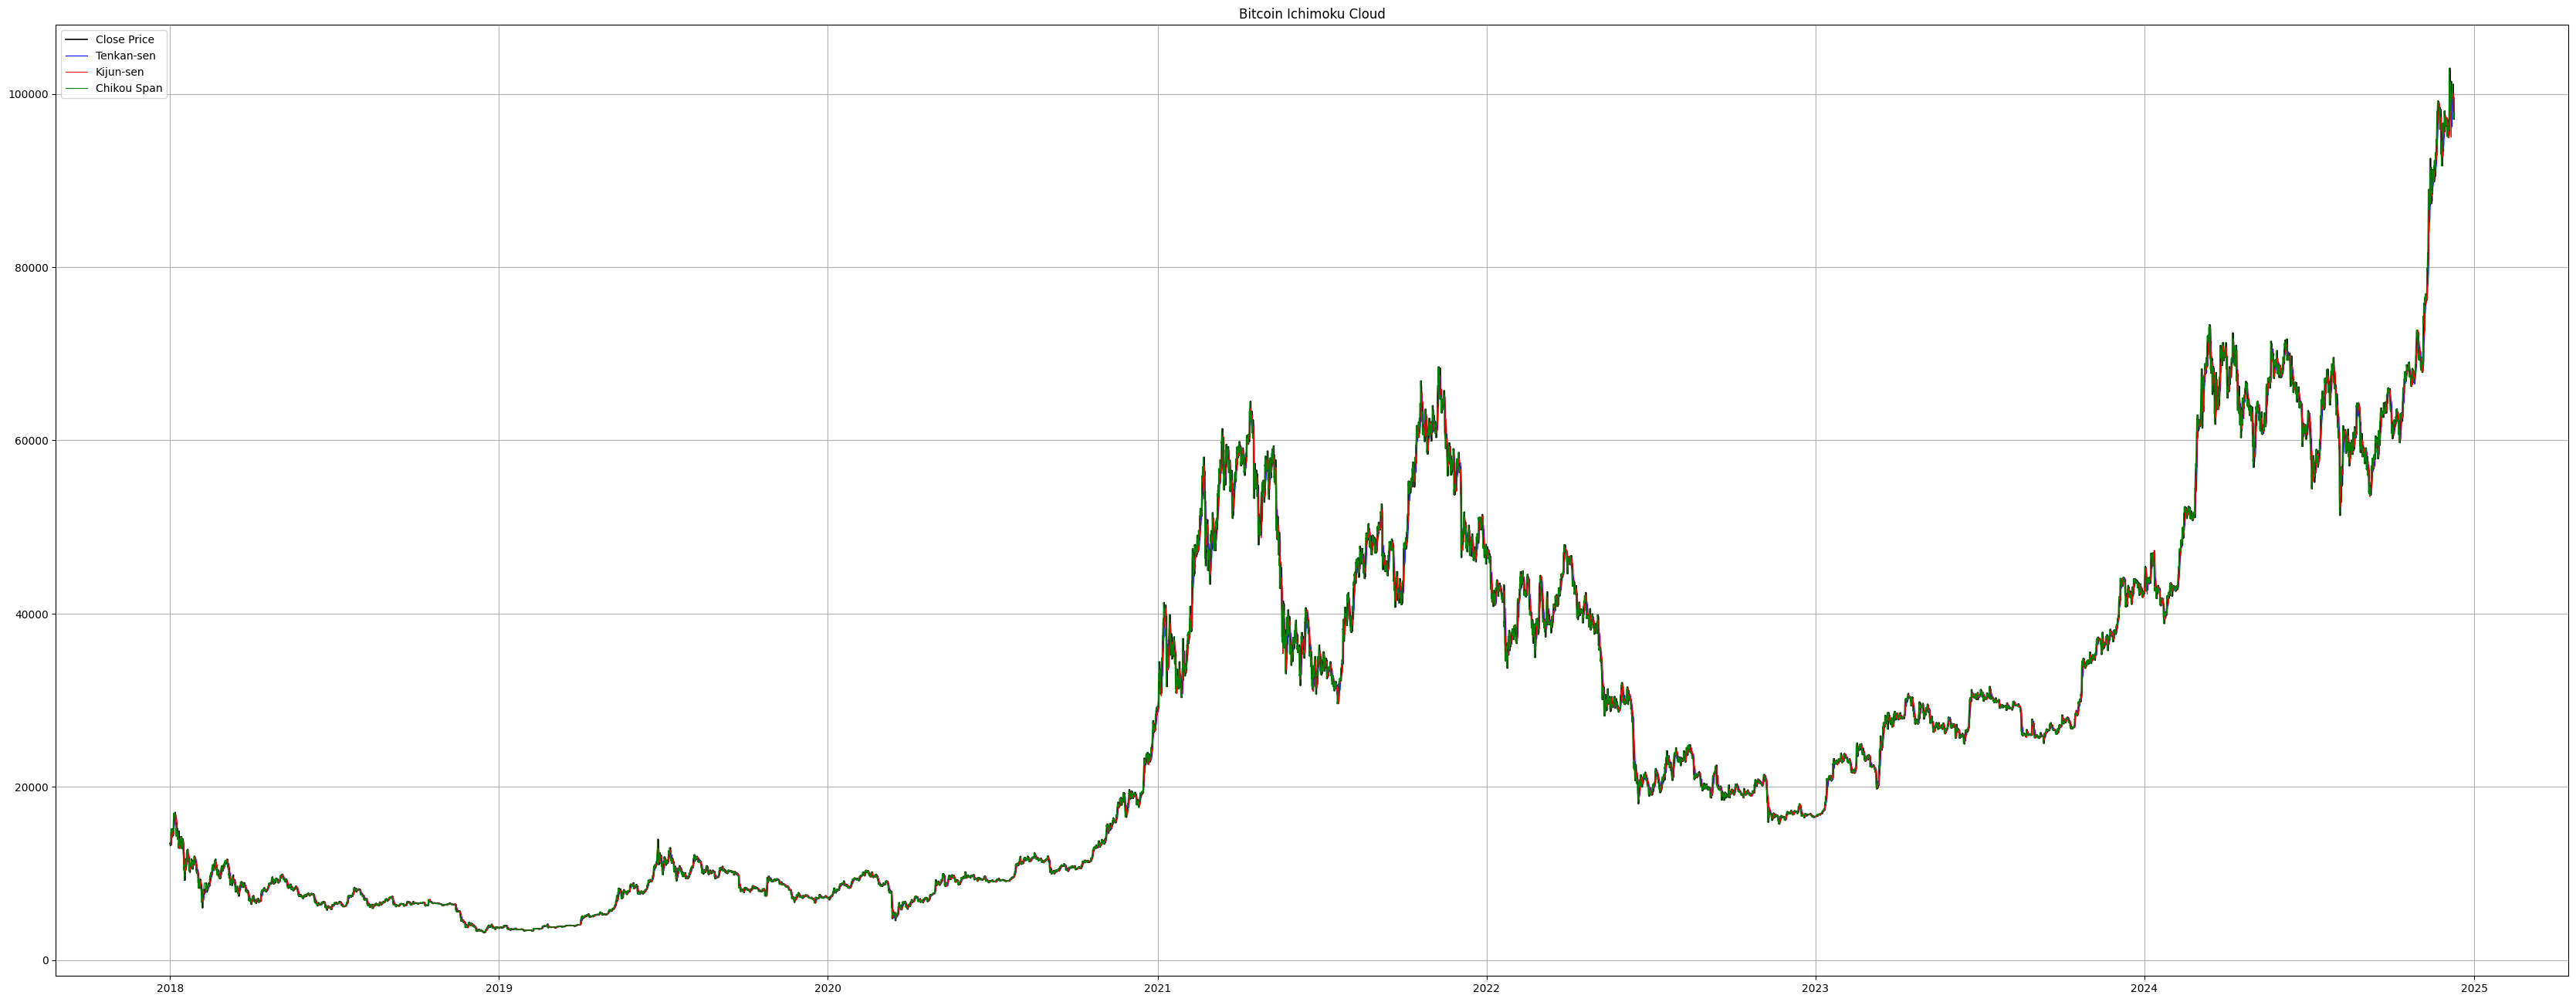

signals
 0    14874
 1      161
-1      160
Name: count, dtype: int64
data: {
  "jupyter_id": "test",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2018-01-01 00:00:00",
      "Total Trades": 160,
      "Leverage Applied": 1.0,
      "Winning Trades": 88,
      "Losing Trades": 72,
      "No. of Long Trades": 160,
      "No. of Short Trades": 0,
      "Benchmark Return(%)": 628.936401,
      "Benchmark Return(on $1000)": 6289.364006,
      "Win Rate": 55.0,
      "Winning Streak": 7,
      "Losing Streak": 8,
      "Gross Profit": 8181.980339,
      "Net Profit": 7941.980339,
      "Average Profit": 49.637377,
      "Maximum Drawdown(%)": 13.720991,
      "Average Drawdown(%)": 1.352972,
      "Largest Win": 1041.783542,
      "Average Win": 114.28852,
      "Largest Loss": -164.435088,
      "Average Loss": -29.380686,
      "Maximum Holding Time": "50 days 12:0:0",
      "Average Holding Time": "8 days 1:1:30",
   

In [ ]:
dataframes = do_it(folder_path)

print(dataframes[0]["signals"].value_counts())

csv_file_path = create_file(dataframes, csv_file_name)

#change to perform_backtest_large_csv(csv_file_path) for large files
backtest_result = perform_backtest_large_csv(csv_file_path)
print(backtest_result)
for value in backtest_result:
    print(value)

if os.path.exists(csv_file_path):
    os.remove(csv_file_path)